# Advanced Topics in Machine Learning - Assignment 2

Students:
- Konstantinos Tsintzas, tsintzask@csd.auth.gr
- George Matlis, gmatl@csd.auth.gr

## Part B: Multi-Instance Learning

Authored by Konstantinos Tsintzas as a Colab notebook.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import scipy.spatial.distance as dist
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Loading Dataset

In [2]:
!wget https://raw.githubusercontent.com/GeorgeM2000/Classification-of-Bird-Recordings/main/birds_brown_creeper.csv

--2024-04-21 11:42:36--  https://raw.githubusercontent.com/GeorgeM2000/Classification-of-Bird-Recordings/main/birds_brown_creeper.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3143482 (3.0M) [text/plain]
Saving to: ‘birds_brown_creeper.csv’

birds_brown_creeper 100%[===================>]   3.00M  --.-KB/s    in 0.03s   

2024-04-21 11:42:36 (115 MB/s) - ‘birds_brown_creeper.csv’ saved [3143482/3143482]



In [3]:
df = pd.read_csv("birds_brown_creeper.csv", header=None, on_bad_lines='skip')

df=df.rename(columns={0:'label',1:'bag'})
df=df.rename(columns=dict(zip(range(2,40),range(0,38))))

n_examples = df['label'].value_counts()
n_bags = df['bag'].nunique()

print(f"Examples per label:\n{n_examples}\n\nUnique bags: {n_bags}")

Examples per label:
label
0    5226
1    5006
Name: count, dtype: int64

Unique bags: 548


In [4]:
display(df)

,label,bag,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,36,37
0,1,1,0.965614,0.943411,0.379381,0.432860,0.001019,0.082413,-0.000008,0.006523,...,0.038549,0.029478,0.079365,0.120181,0.095238,0.047619,0.049887,0.020408,0.034014,0.045351
1,1,1,0.967565,0.950808,0.405369,0.475816,0.001144,0.070473,0.000010,0.003011,...,0.063492,0.024691,0.082892,0.123457,0.081129,0.051146,0.037037,0.033510,0.029982,0.068783
2,1,1,0.952911,0.947422,0.394286,0.510015,0.000514,0.075422,0.000002,0.000494,...,0.047120,0.049738,0.083770,0.023560,0.065445,0.083770,0.054974,0.060209,0.054974,0.109948
3,1,1,0.951422,0.972968,0.401513,0.531201,0.000482,0.073074,-0.000001,-0.001808,...,0.020380,0.021739,0.047554,0.031250,0.065217,0.082880,0.191576,0.055707,0.028533,0.008152
4,1,1,0.952263,0.887658,0.423270,0.565426,0.000505,0.073105,-0.000001,-0.003650,...,0.028409,0.045455,0.232955,0.068182,0.039773,0.039773,0.028409,0.045455,0.039773,0.056818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10227,0,548,0.944063,0.912176,0.575621,0.503158,0.000370,0.080901,0.000000,0.000907,...,0.043269,0.048077,0.115385,0.091346,0.081731,0.038462,0.033654,0.033654,0.038462,0.076923
10228,0,548,0.985057,0.969313,0.845439,0.602794,0.008721,0.063828,-0.000657,-0.010000,...,0.037534,0.091153,0.175871,0.079893,0.032172,0.057909,0.028418,0.032708,0.039678,0.041287
10229,0,548,0.986260,0.941764,0.780768,0.322445,0.007284,0.045391,-0.000153,0.011332,...,0.046015,0.113394,0.197206,0.147905,0.020542,0.013147,0.010682,0.012325,0.021364,0.041906
10230,0,548,0.974982,0.887446,0.759451,0.519539,0.001834,0.076134,0.000008,-0.001731,...,0.019444,0.058333,0.238889,0.088889,0.019444,0.008333,0.002778,0.008333,0.013889,0.083333


Let's see the size range of the bags in the dataset.

In [5]:
df_bags = df.groupby(by=['bag'])
bagsizes = df_bags.size().value_counts().sort_index()

print("Bag Sizes\n")
print(f"Smallest bag size: {bagsizes.index.min()}\n Largest bag size: {bagsizes.index.max()}")

Bag Sizes

Smallest bag size: 2
 Largest bag size: 43


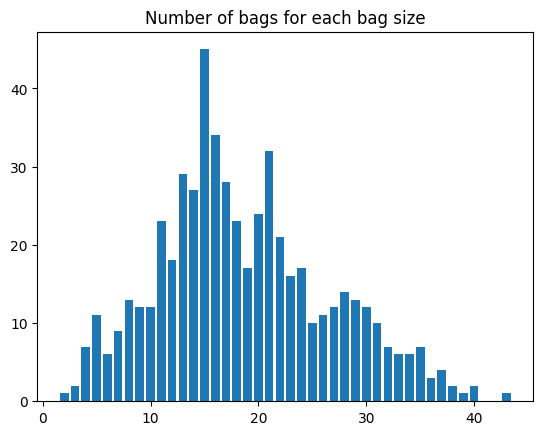

In [6]:
plt.bar(bagsizes.index,bagsizes)
plt.title("Number of bags for each bag size")
plt.show()

As we can see, 15 examples is the most common size for a bag, but they range from 2 to 43. Most bags fall in the 10-25 examples range.

Next, we're splitting into train and test bags. We'll use the same split for all classification methods we'll try.

In [7]:
random.seed(64)

test_size = 0.3
n_test_bags = int(n_bags*test_size)

test_bags_list = random.sample(list(df['bag'].unique()),n_test_bags)

test_df = df.loc[df["bag"].isin(test_bags_list)].copy()

train_df = df.loc[~df["bag"].isin(test_bags_list)].copy()

After splitting, let's take a look at the training set.

In [8]:
train_bags = train_df.groupby(by=['bag'])
train_bagsizes = train_bags.size().value_counts().sort_index()

train_examples = train_df['label'].value_counts()
train_bags = train_df['bag'].nunique()

print("Training Set Bags\n")

print(f"Examples per label:\n{train_examples}\n\nUnique bags: {train_bags}\n")
print("Bag Sizes")
print(f"Smallest bag size: {train_bagsizes.index.min()}\n Largest bag size: {train_bagsizes.index.max()}")

Training Set Bags

Examples per label:
label
0    3795
1    3360
Name: count, dtype: int64

Unique bags: 384

Bag Sizes
Smallest bag size: 2
 Largest bag size: 43


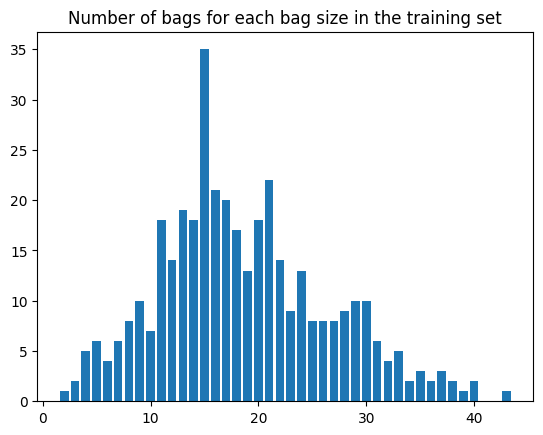

In [9]:
plt.bar(train_bagsizes.index,train_bagsizes)
plt.title("Number of bags for each bag size in the training set")
plt.show()

A pretty decent split that more-or-less preserves the distribution we had previously.

# Method 1: Bag Representations Based on Instance Clustering

For this method, we're clustering all examples, and each cluster represents a feature in a new feature space. If a bag has examples in a given cluster, that cluster's corresponding feature will be a 1 for that bag, otherwise it'll be a 0.

In [10]:
x = train_df.drop(columns=["label","bag"])

kmeans = KMeans(n_clusters=10,n_init='auto')
kmeans.fit(x)
train_df["cluster"] = kmeans.predict(x)

In [11]:
train_df["cluster"].value_counts()

cluster
7    4924
0     901
8     657
2     389
5     139
1      59
9      55
4      28
3       2
6       1
Name: count, dtype: int64

After clustering and checking on the distribution of the clusters, we're going to transform our dataset to the new feature space.

In [12]:
clusters_dict = dict(zip(train_df.index,train_df["cluster"]))
transformed_train_df = pd.DataFrame(columns=["label","bag"]+sorted(train_df["cluster"].unique()))

for bag in train_df["bag"].unique():
  indices = list(train_df.loc[train_df["bag"]==bag].index)
  label = train_df["label"][indices[0]]
  row = [0]*10
  for i in indices:
    row[int(train_df["cluster"][i])] = 1
  transformed_train_df.loc[len(transformed_train_df)] = [label,bag]+row

transformed_train_df = transformed_train_df.set_index(transformed_train_df["bag"]).drop(columns=["bag"])

display(transformed_train_df)

,label,0,1,2,3,4,5,6,7,8,9
bag,,,,,,,,,,,
2,1,1,0,0,0,0,0,0,1,1,1
3,1,1,0,1,0,0,0,0,1,1,0
4,1,0,0,1,0,0,0,0,1,1,0
7,1,1,0,0,0,0,0,0,1,1,0
8,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
544,0,1,0,0,0,1,0,0,1,0,0
545,0,1,0,1,0,1,0,0,1,0,0
546,0,1,0,1,0,0,1,0,1,0,1


In [13]:
def transform_bag(new_bag):

  clusters = list(kmeans.predict(new_bag.drop(columns=["label","bag"])))
  row = [0]*10

  for i in clusters:
    row[i] = 1

  return row

We've transformed the training set, and defined a function to transform the test set as well. next, we're also transforming the test set.

In [14]:
transformed_test_df = pd.DataFrame(columns=["label","bag"]+sorted(range(10)))

for bag in test_df["bag"].unique():
  indices = list(test_df.loc[test_df["bag"]==bag].index)
  label = test_df["label"][indices[0]]
  row = transform_bag(test_df.loc[test_df["bag"]==bag])
  transformed_test_df.loc[len(transformed_test_df)] = [label,bag]+row

transformed_test_df = transformed_test_df.set_index(transformed_test_df["bag"]).drop(columns=["bag"])

display(transformed_test_df)

,label,0,1,2,3,4,5,6,7,8,9
bag,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,1,0
5,1,1,0,0,0,0,0,0,1,1,0
6,1,1,0,0,0,0,0,0,1,1,0
13,1,1,0,0,0,0,0,0,1,1,0
16,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
519,0,1,0,1,0,1,0,0,1,1,0
528,0,1,1,0,0,0,0,0,1,1,1
532,0,1,1,0,0,0,1,0,1,0,1


Now, to classify the examples using a few different methods.

In [15]:
classifiers = [LogisticRegression(random_state=123),
               RandomForestClassifier(n_estimators=100,random_state=123),
               KNeighborsClassifier(n_neighbors=5),
               MLPClassifier(hidden_layer_sizes=(100,))]

results = []

train_x = transformed_train_df.drop(columns=["label"])
train_y = transformed_train_df["label"]

test_x = transformed_test_df.drop(columns=["label"])
test_y = transformed_test_df["label"]

for classifier in classifiers:

  classifier.fit(train_x,train_y)
  pred_y = classifier.predict(test_x)
  results.append([classifier,classification_report(test_y,pred_y)])

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
for result in results:
  print(result[0])
  print(result[1])

LogisticRegression(random_state=123)
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        97
           1       0.52      0.43      0.47        67

    accuracy                           0.60       164
   macro avg       0.58      0.58      0.58       164
weighted avg       0.59      0.60      0.60       164

RandomForestClassifier(random_state=123)
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        97
           1       0.80      0.49      0.61        67

    accuracy                           0.74       164
   macro avg       0.76      0.71      0.71       164
weighted avg       0.76      0.74      0.73       164

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.90      0.55      0.68        97
           1       0.58      0.91      0.71        67

    accuracy                           0.70       164
   macro avg       0.74    

As we can see from comparing the different methods on the new feature space, the best results were achieved by the random forest and MLP classifiers, with the random forest narrowly winning out. Logistic regression comes after them, and k-nearest neighbors takes the last spot - notably, it also sports the highest precision and lowest recall score.

# Method 2: K-Nearest Neighbors Using Hausdorff Distance

For our next method, we'll simply implement k-nearest neighbors between the bags, utilizing the Hausdorff distance measure to rank nearest neighbors.

First, we'll prepare the train and test set in suitable forms.

In [17]:
train_bags = train_df.groupby(by=['bag'])
test_bags = test_df.groupby(by=['bag'])

train_x = []
train_y = []

test_x = []
test_y = []

for name,group in train_bags:
  train_x.append(group.drop(columns=["label","bag","cluster"],errors='ignore'))
  train_y.append(group.sample()["label"].iloc[0])

for name,group in test_bags:
  test_x.append(group.drop(columns=["label","bag","cluster"],errors='ignore'))
  test_y.append(group.sample()["label"].iloc[0])

Next, we'll implement our KNN class.

Hausdorff distance function is a modified version of this one found on Github: https://github.com/arjunssharma/Citation-KNN/blob/master/CitationKNN.py

In [18]:
class HausdorffKNN():

    def __init__(self):
      self.bags = None

    def fit(self, train_bags:list, train_labels:list, n_neighbors:int):
      self.bags = train_bags
      self.labels = train_labels
      self.neighbors = n_neighbors

    def predict(self, test_bags:list):

      predictions = []

      for test_bag in test_bags:
        distances_labels = []

        for train_bag,label in zip(self.bags,self.labels):
          distance = self.hausdorff_distance(test_bag,train_bag)
          distances_labels.append((distance,label))

        voters = sorted(distances_labels, key=lambda n: n[0])[0:self.neighbors]
        voter_labels = [n[1] for n in voters]
        pred,count = Counter(voter_labels).most_common()[0]
        predictions.append(pred)

      return predictions

    def hausdorff_distance(self,bag1,bag2):
      X = bag1.to_numpy()
      Y = bag2.to_numpy()
      distance = max(min((min([list(dist.euclidean(x, y) for y in Y) for x in X]))),min((min([list(dist.euclidean(x, y) for x in X) for y in Y]))))
      return distance

Finally, let's classify the test set bags.

In [19]:
knn = HausdorffKNN()
knn.fit(train_x,train_y,5)
pred_y = knn.predict(test_x)

knn_result = (classification_report(test_y,pred_y))
print(knn_result)

              precision    recall  f1-score   support

           0       0.76      0.75      0.76        97
           1       0.65      0.66      0.65        67

    accuracy                           0.71       164
   macro avg       0.70      0.70      0.70       164
weighted avg       0.71      0.71      0.71       164



Compared to the previous method, our Hausdorff KNN algorithm performed worse than the random forest and the MLP, but better than the other two tested methods.

However, my implementation of the KNN algorithm is rather naive and inefficient, and does not implement any additional data structures to make calculations faster. This makes it much more time-consuming during the prediction stage.

# Conclusion

For this particular dataset, a random forest classifier implemented on a feature space based on instance clustering was the best option out of those tested.

Overall precision, recall, and f1-scores were not particularly impressive, but not awful either (aside from k-nearest neighbors on the instance clustering feature space). Additionally, taking the Hausdorff distance-based KNN implementation into account, the Hausdorff distance measure has proved to be useful in this classification task.